# Basic Usage

In [7]:
## Setup

import os
import pandas as pd
import numpy as np
import astropy.units as u
import astropy.constants as const
import mpear
import matplotlib.pyplot as plt


#plus any other environment variables

## 1. Orbital Mechanics

In [8]:
# Example: Calculate Earth's orbit
earth_orbit = mpear.calculate_full_orbit(
    r=const.au,
    inclination=np.radians(0),
    UpOmega=np.radians(0),
    omega=np.radians(90),
    d=(10 * u.pc).to(u.m),
    save=True,
    filename="earth_orbit.txt",
)


# Find orbits that match target position (condition 1)
target_position = (0.0, -0.1)  # arcsec (x,y)
d = (10 * u.pc).to(u.m)
a_range = np.arange(1, 10, 1)  # AU
i_range = np.arange(0, 180, 10)  # degrees
t_range = np.arange(0, 360, 10)  # TRUE ANOMALY degrees
UpOmega = np.radians(0)
omega = np.radians(-90)
tolerance = 0.01  # arcsec

# Saves into matrices.npz and next time it will check if the ranges are the same. If so, it does not recompute but just reads the file (saves time).
matrix, max_matrix = mpear.load_or_calculate_matrix(
    'matrices.npz', 
    mpear.find_matching_orbits, # this function calculates if (a,i,t) produces a detection within the tolerance that you established. If so, the orbit is compatible
    target_position, d, a_range, i_range, t_range, UpOmega, omega, tolerance,
)

# Calculate and store full orbits previously identified as compatible (useful for plotting)
orbit_metadata = mpear.calculate_and_store_orbits(
    matrix,
    tolerance,
    a_range,
    i_range,
    t_range,
    UpOmega,
    omega,
    d,
    'orbit_data', # all the orbits in (X,Y,Z) space will be saved here, one file per orbit
    recalculate=True,
)



Loaded existing data from matrices.npz


## 2. Flux Calculations
Uses PSG in Docker to calculate spectra. Make sure you have PSG Docker installed!

In [9]:
# Calculate and store spectra of the compatible orbits (using orbit_metadata)
spectrum_metadata = mpear.psg_calculate_and_store_spectra(
    orbit_metadata,
    'planet_template.txt', # link to the template atmosphere you are using to differentiate
    'spectra_output', # folder where to save results
    recalculate=False
)


Calculating spectrum for a1.00_i0.00_t180.00 and saving to spectra_output/rad_a1.00_i0.00_t180.00.txt
Calculating spectrum for a1.00_i10.00_t180.00 and saving to spectra_output/rad_a1.00_i10.00_t180.00.txt
Calculating spectrum for a1.00_i20.00_t180.00 and saving to spectra_output/rad_a1.00_i20.00_t180.00.txt
Calculating spectrum for a2.00_i60.00_t180.00 and saving to spectra_output/rad_a2.00_i60.00_t180.00.txt
Calculating spectrum for a3.00_i70.00_t180.00 and saving to spectra_output/rad_a3.00_i70.00_t180.00.txt
Calculating spectrum for a6.00_i80.00_t180.00 and saving to spectra_output/rad_a6.00_i80.00_t180.00.txt
Calculating spectrum for a6.00_i100.00_t0.00 and saving to spectra_output/rad_a6.00_i100.00_t0.00.txt
Calculating spectrum for a3.00_i110.00_t0.00 and saving to spectra_output/rad_a3.00_i110.00_t0.00.txt
Calculating spectrum for a2.00_i120.00_t0.00 and saving to spectra_output/rad_a2.00_i120.00_t0.00.txt
Calculating spectrum for a1.00_i160.00_t0.00 and saving to spectra_outpu

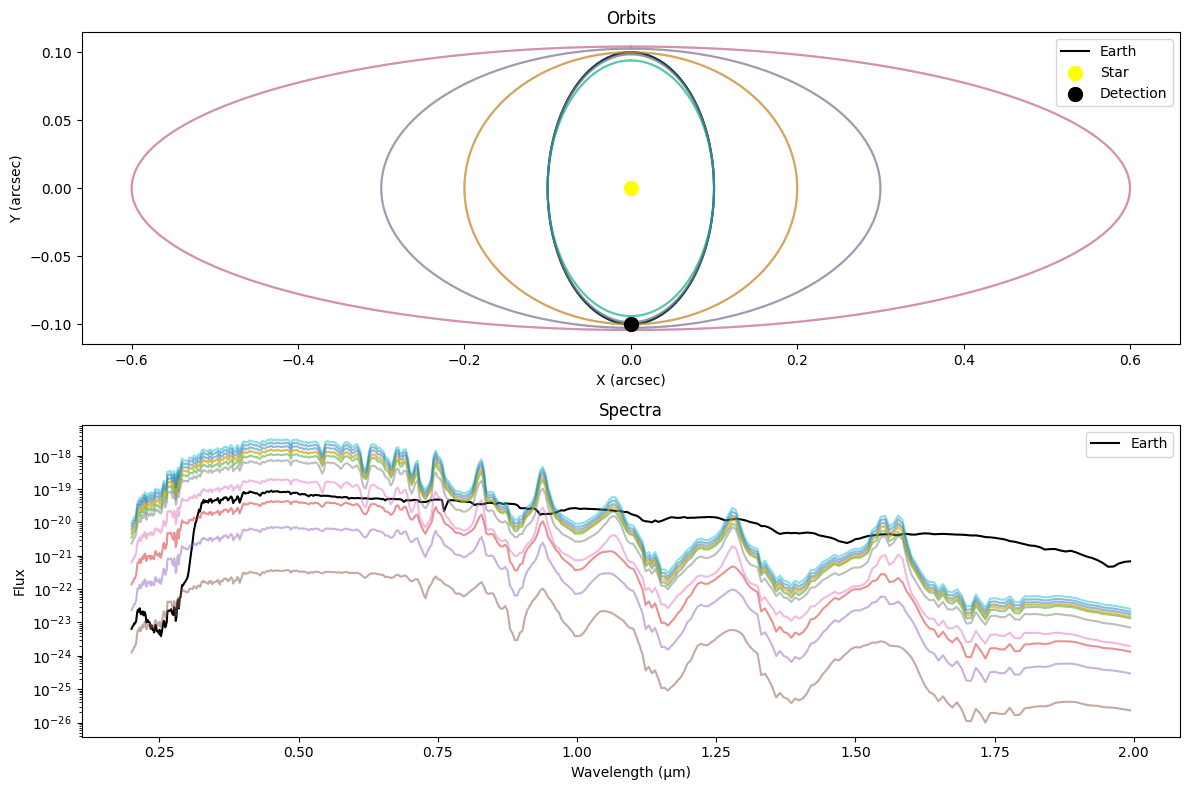

In [10]:
# Let's plot them:
# Load data
orbit_metadata = pd.read_csv('orbit_data/orbit_metadata.csv')
spectrum_metadata = pd.read_csv('spectra_output/spectrum_metadata.csv')
earth_orbit = np.loadtxt('earth_orbit.txt')
earth_spectrum = np.loadtxt('earth_spectrum.txt')

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot Earth's orbit
ax1.plot(earth_orbit[:, 0], earth_orbit[:, 1], 'k', label='Earth')

# Plot Star
ax1.scatter(0, 0, color='yellow', s=100, label='Star')

# Plot detection
ax1.scatter(0, -0.1, color='black', s=100, label='Detection',zorder=101)



# Plot other orbits and spectra
for _, row in orbit_metadata.iterrows():
    orbit = np.loadtxt(row['file'])
    # Plot orbit
    ax1.plot(orbit[:, 0], orbit[:, 1], alpha=0.5)
    

# Plot Earth's spectrum
wavelength = earth_spectrum[:, 0]
earth_flux = earth_spectrum[:, -1]
ax2.plot(wavelength, earth_flux, 'k', label='Earth')

for _, row in spectrum_metadata.iterrows():
    spectrum = np.loadtxt(row['file'])    
    # Plot spectrum
    ax2.plot(spectrum[:, 0], spectrum[:, -1], alpha=0.5)

# Customize plots
ax1.set_xlabel('X (arcsec)')
ax1.set_ylabel('Y (arcsec)')
ax1.set_title('Orbits')
ax1.legend()

ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Flux')
ax2.set_title('Spectra')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Noise simulations

Uses pyEDITH to calculate the noise associated to specific bandpasses. Make sure you have pyEDITH installed!

For details on the keywords that pyEDITH needs, check the [documentation](https://pyedith.readthedocs.io/en/latest/).

It starts with calculating the exposure time needed to get to SNR=7 in the primary bandpass (500 nm). 

Then, it sweeps the wavelength range point by point creating bandpasses (of a given bandwidth) that can reasonably fit into the UV/VIS/NIR channels. That means that the full bandpass must fit within the channel.



In [11]:
parameters = {
    'wavelength': [0.5],
    'resolution': [5],
    'snr': [7],
    'photometric_aperture_radius': 0.85,
    'CRb_multiplier': 2.0,
    'Lstar': 1,
    'distance': 10,
    'stellar_radius': 1,
    'nzodis': 3.0,
    'ra': 236.00757736823,
    'dec': 2.51516683165,
    'separation': 0.1,
    'observatory_preset': 'ToyModel',
    'observing_mode': 'IMAGER',
    'bandwidth': 0.2,
}

secondary_parameters = parameters.copy()
bandwidths = [0.2]

observed_bandwidths_earth, _, _, texp = mpear.sweep_bandpasses(
    'earth_spectrum.txt', # your favorite flux (ideally the one that most confuses you)
    parameters,
    secondary_parameters,
    bandwidths,
    scan_number=50, # "full" if you want to try every point, otherwise pick a number N and it will take points every N
    savefolder='noise/earth_' # where to save results
)

observed_bandwidths_planet, _, _, texp = mpear.sweep_bandpasses(
    'planet_spectrum.txt', # your favorite flux (ideally the one that most confuses you)
    parameters,
    secondary_parameters,
    bandwidths,
    scan_number=50, # "full" if you want to try every point, otherwise pick a number N and it will take points every N
    savefolder='noise/planet_' # where to save results
)



Observatory Configuration:
  Using preset: ToyModel

Calculating noisefloor by multiplying noisefloor_factor=0.03, contrast=1.05e-13, PSFpeak=0.01625
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Reference exposure time:  [3.17234252] h
Observatory Configuration:
  Using preset: ToyModel

Calculating noisefloor by multiplying noisefloor_factor=0.03, contrast=1.05e-13, PSFpeak=0.01625
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Reference exposure time:  [3.13290409] h


# 4. Calculate significance

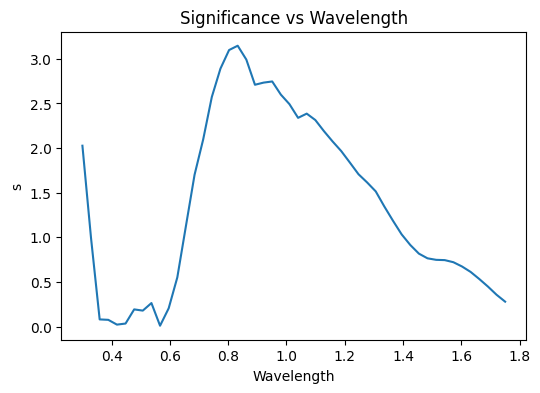

In [12]:
wavelength = [s for s in observed_bandwidths_earth[0.2]['wavelength'].values]

earth_flux = observed_bandwidths_earth[0.2]['flux'].values
earth_snr = [s.value for s in observed_bandwidths_earth[0.2]['snr'].values]
neptune_flux = observed_bandwidths_planet[0.2]['flux'].values
neptune_snr = [s.value for s in observed_bandwidths_planet[0.2]['snr'].values]

flux_diff = np.abs(earth_flux - neptune_flux)
combined_error = np.sqrt((earth_flux / earth_snr)**2 + (neptune_flux / neptune_snr)**2)
significance = flux_diff / combined_error

plt.figure(figsize=(6, 4))
plt.plot(wavelength, significance)
plt.xlabel('Wavelength')
plt.ylabel('s')
plt.title('Significance vs Wavelength')
plt.show()
